# Text preprocessing

## Google's BERT

In [1]:
import pandas as pd
import pickle
from pytorch_pretrained_bert import BertTokenizer, BertModel
import torch
from tqdm import tqdm_notebook as tqdm

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
# Model imports
cuda = torch.device('cuda')
bert = BertModel.from_pretrained('bert-base-uncased').to(cuda)
bert.eval()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
infos = pickle.load(open('../data/infos.p', 'rb'))

In [4]:
infos[1]

{'adult': False,
 'collection': 10194,
 'genres': [16, 35, 10751],
 'original_language': 'en',
 'overview': "Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",
 'popularity': 25.398,
 'production_companies': [3],
 'production_countries': ['us'],
 'release_year': 1995,
 'release_month': 10,
 'revenue': 373554033,
 'runtime': 81,
 'spoken_languages': ['en'],
 'tagline': '',
 'title': 'Toy Story',
 'vote_average': 7.9,
 'vote_count': 9787,
 'budget': 30000000,
 'revenue_d': 343554033}

In [5]:
infos_tensor = {}
for k,v in tqdm(infos.items()):
    v = (v['overview'] + v['tagline'] + v['title'])[:512]
    v = tokenizer.tokenize(v)
    v = tokenizer.convert_tokens_to_ids(v)
    v = torch.tensor(v).to(cuda)
    infos_tensor[k] = v

In [6]:
from collections import OrderedDict
infos_sorted = OrderedDict(sorted(infos_tensor.items(), key=lambda t: t[1].size()))

In [7]:
infos_bert = {}
batch = []
indexes = []
max_size = 0
batch_size = 10

for i in tqdm(range(len(infos_sorted))):
    idx, tensor = infos_sorted.popitem()
    batch.append(tensor)
    indexes.append(idx)
    
    if len(batch) >= batch_size:
        seq_lengths = torch.tensor([len(seq) for seq in batch]).long().cuda()
        seq_tensor = torch.zeros((len(batch), seq_lengths.max())).long().cuda()
        
        for idx, (seq, seqlen) in enumerate(zip(batch, seq_lengths)):
            seq_tensor[idx, :seqlen] = torch.tensor(seq).long().cuda()
            
        _, output = bert(seq_tensor)

        output = output.detach().cpu()
        for i in range(output.size(0)):
            infos_bert[indexes[i]] = output[i]
            
        batch = []
        indexes = []
    

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [8]:
seq_lengths = torch.tensor([len(seq) for seq in batch]).long().cuda()
seq_tensor = torch.zeros((len(batch), seq_lengths.max())).long().cuda()

for idx, (seq, seqlen) in enumerate(zip(batch, seq_lengths)):
    seq_tensor[idx, :seqlen] = torch.tensor(seq).long().cuda()
            
    _, output = bert(seq_tensor)

    output = output.detach().cpu()
    for i in range(output.size(0)):
        infos_bert[indexes[i]] = output[i]

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [9]:
pickle.dump(dict([(i[0], i[1].numpy()) for i in infos_bert.items()]),
            open('../data/texts_bert.p', 'wb'))

## GPT 2

In [1]:
import pandas as pd
import pickle
from pytorch_pretrained_bert import GPT2Tokenizer, GPT2Model
import torch
from tqdm import tqdm_notebook as tqdm

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
cuda = torch.device('cuda')
gpt2 = GPT2Model.from_pretrained('gpt2').to(cuda)
gpt2.eval()

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [3]:
infos = pickle.load(open('../data/infos.p', 'rb'))

In [4]:
infos_tensor = {}
for k,v in tqdm(infos.items()):
    v = (v['overview'] + v['tagline'] + v['title'])[:512]
    v = tokenizer.encode(v)
    v = torch.tensor(v).to(cuda)
    infos_tensor[k] = v

In [5]:
from collections import OrderedDict
infos_sorted = OrderedDict(sorted(infos_tensor.items(), key=lambda t: t[1].size()))

In [6]:
infos_gpt2 = {}
batch = []
indexes = []
max_size = 0
batch_size = 5

for i in tqdm(range(len(infos_sorted))):
    idx, tensor = infos_sorted.popitem()
    batch.append(tensor)
    indexes.append(idx)
    
    if len(batch) >= batch_size:
        seq_lengths = torch.tensor([len(seq) for seq in batch]).long().cuda()
        seq_tensor = torch.zeros((len(batch), seq_lengths.max())).long().cuda()
        
        for idx, (seq, seqlen) in enumerate(zip(batch, seq_lengths)):
            seq_tensor[idx, :seqlen] = torch.tensor(seq).long().cuda()
            
        output, _ = gpt2(seq_tensor)
        output = output[:,-1]
        output = output.detach().cpu()
        for i in range(output.size(0)):
            infos_gpt2[indexes[i]] = output[i]
            
        batch = []
        indexes = []

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
seq_lengths = torch.tensor([len(seq) for seq in batch]).long().cuda()
seq_tensor = torch.zeros((len(batch), seq_lengths.max())).long().cuda()

for idx, (seq, seqlen) in enumerate(zip(batch, seq_lengths)):
    seq_tensor[idx, :seqlen] = torch.tensor(seq).long().cuda()
            
    _, output = gpt2(seq_tensor)
    
    output = output[:,-1]
    output = output.detach().cpu()
    
    for i in range(output.size(0)):
        infos_gpt2[indexes[i]] = output[i]

In [7]:
pickle.dump(dict([(i[0], i[1].numpy()) for i in infos_gpt2.items()]),
            open('../data/texts_gpt2.p', 'wb'))

# Label Encoding

In [1]:
import pandas as pd
import pickle

In [2]:
infos = pickle.load(open('../data/infos.p', 'rb'))

### Multilabel

In [3]:
def multicat_label_encode(infos, col, trim=0):
    col_sort = list()
    [col_sort.extend(set(i[col])) for i in infos.values()]
    col_sort = pd.Series(col_sort).value_counts().index.tolist()
    if trim: col_sort = col_sort[:trim]
    col_dict = dict([(k, idx) for idx, k in enumerate(col_sort)])
    for i in infos.keys():
        infos[i][col] = list(map(col_dict.get, infos[i][col]))
    print(col, 'unique:', len(col_sort))

In [4]:
multicat_label_encode(infos, 'genres')
multicat_label_encode(infos, 'production_countries')
multicat_label_encode(infos, 'spoken_languages')
multicat_label_encode(infos, 'production_companies', 500)

genres unique: 23
production_countries unique: 151
spoken_languages unique: 140
production_companies unique: 500


### Unilabel

In [5]:
def label_encode(infos, col, trim=0):
    col_sort = pd.Series([i[col] for i in infos.values()]).value_counts().index.tolist()
    if trim: col_sort = col_sort[:trim]
    col_dict = dict([(k, idx) for idx, k in enumerate(col_sort)])
    for i in infos.keys():
        infos[i][col] = col_dict.get(infos[i][col])
    print(col, 'unique:', len(col_sort))

In [6]:
label_encode(infos, 'collection', 910)
label_encode(infos, 'original_language')

collection unique: 910
original_language unique: 89


In [7]:
infos[1]

{'adult': False,
 'collection': 210,
 'genres': [14, 1, 11],
 'original_language': 0,
 'overview': "Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",
 'popularity': 25.398,
 'production_companies': [96],
 'production_countries': [0],
 'release_year': 1995,
 'release_month': 10,
 'revenue': 373554033,
 'runtime': 81,
 'spoken_languages': [0],
 'tagline': '',
 'title': 'Toy Story',
 'vote_average': 7.9,
 'vote_count': 9787,
 'budget': 30000000,
 'revenue_d': 343554033}

## Standartization

In [8]:
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='monokai')

In [9]:
def standardize(infos, col, plot=True, bins=100):
    scaler = preprocessing.StandardScaler()
    a = np.array([i[col] or 0 for i in infos.values()])
    if plot:
        plt.subplot(2, 1, 1)
        plt.hist(a, bins=bins)
        plt.ylabel('Before')
    a = a.reshape(-1, 1)
    scaler = scaler.fit(a)
    for i in infos.keys():
        infos[i][col] = scaler.transform([[infos[i][col]]])[0,0]
        
    if plot:
        plt.subplot(2, 1, 2)
        plt.hist([i[col] for i in infos.values()], bins=bins)
        plt.ylabel('After')
        plt.show()

/home/dev/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/dev/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dev/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


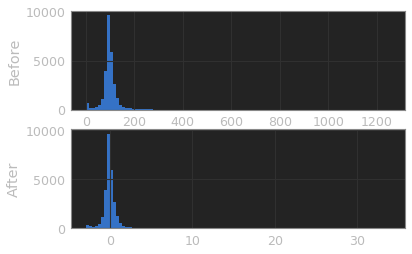

In [10]:
standardize(infos, 'runtime')

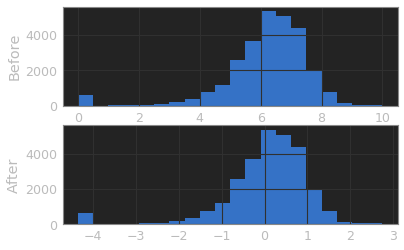

In [11]:
standardize(infos, 'vote_average', bins=20)

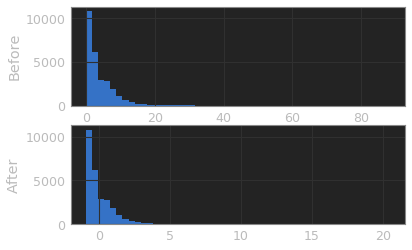

In [12]:
standardize(infos, 'popularity', bins=50)

/home/dev/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


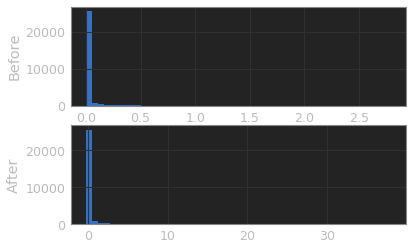

In [13]:
standardize(infos, 'revenue', bins=50)

/home/dev/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


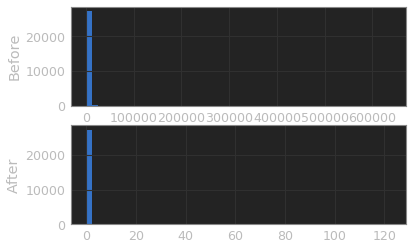

In [14]:
standardize(infos, 'vote_count', bins=50)

/home/dev/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


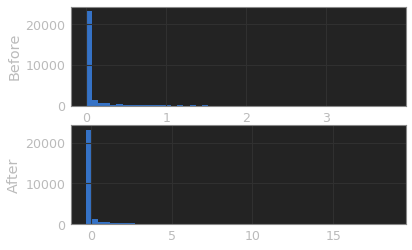

In [15]:
standardize(infos, 'budget', bins=50)

/home/dev/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


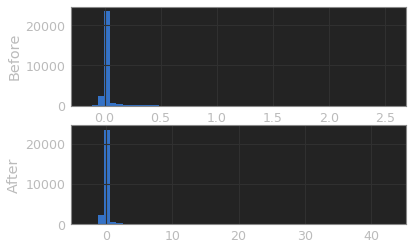

In [16]:
standardize(infos, 'revenue_d', bins=50)

In [17]:
for i in infos.keys():
    del infos[i]['overview']
    del infos[i]['tagline']
    del infos[i]['title']
    infos[i]['production_companies'] = [i for i in infos[i]['production_companies'] 
                                        if i is not None]

In [20]:
infos[2]

{'adult': False,
 'collection': None,
 'genres': [7, 12, 11],
 'original_language': 0,
 'popularity': 0.1084208585916617,
 'production_companies': [13, 128],
 'production_countries': [0],
 'release_year': 1995,
 'release_month': 12,
 'revenue': 3.376926602813796,
 'runtime': 0.16506363730309434,
 'spoken_languages': [0, 1],
 'vote_average': 0.7597458971107176,
 'vote_count': 1.022352295938305,
 'budget': 2.9205324409756246,
 'revenue_d': 3.1674092020808633}

In [18]:
pickle.dump(infos,  open( "../data/processed_infos.p", "wb" ))

## Pytorch integration

In [21]:
texts = pickle.load(open('../data/texts_bert.p', 'rb'))

In [37]:
from tqdm import tqdm_notebook as tqdm
import torch

tensor_dict = {}

for i in tqdm(infos.keys()):
    
    # (cathegorical data encodeing)
    # [multicat] array[[indexes]] = 1
    # genres unique: 23
    # production_countries unique: 151
    # spoken_languages unique: 140
    # production_companies unique: 500
    # [unicat] array[index] = 1
    # collection unique: 910
    # original_language unique: 89
    
    genres = torch.zeros(1, 23)
    production_countries = torch.zeros(1, 151)
    spoken_languages = torch.zeros(1, 140)
    production_companies = torch.zeros(1, 500)
    collection = torch.zeros(1, 910)
    original_language = torch.zeros(1, 89)

    genres[0][[infos[i]['genres']]] = 1
    production_countries[0][[infos[i]['production_countries']]] = 1
    spoken_languages[0][[infos[i]['spoken_languages']]] = 1
    production_companies[0][[infos[i]['production_companies']]] = 1
    if infos[i]['collection'] is not None:
        collection[0][infos[i]['collection']] = 1
    original_language[0][infos[i]['original_language']] = 1

    misc = torch.tensor([[infos[i]['adult'], infos[i]['popularity'],
                       infos[i]['release_year'], infos[i]['release_month'],
                       infos[i]['revenue'],infos[i]['runtime'],
                       infos[i]['vote_average'],infos[i]['vote_count'],
                       infos[i]['budget'],infos[i]['revenue_d'],
                       ]])
    
    text = torch.from_numpy(texts[i])
    text = text.unsqueeze(0)
    item = torch.cat([genres, production_countries,
                     spoken_languages, production_companies,
                     collection, original_language,
                     misc, text], 1)
    
    # note may produce some nans!
    item[torch.isnan(item)] = 0
    tensor_dict[i] = item.squeeze()

In [40]:
pickle.dump(tensor_dict,  open( "../data/infos.pytorch", "wb"))

## AutoEncoders for Unsupervised Feature Learning
### Not working

It just seems to binary label encode it with tanh function. So there is 128 bit combination. Yucky.

**Try PCA instead**

In [5]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import pickle

sns.set()
cuda = torch.device('cuda')

In [51]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(2591, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.Tanh()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 2591),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [137]:
movies = pickle.load(open('../data/infos.pytorch', 'rb'))

In [138]:
data = torch.stack(list(movies.values())).to(cuda)
data[torch.isnan(data)] = 0

In [139]:
n_epochs = 500
batch_size = 1024

model = AutoEncoder().to(cuda)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=10e-5)
run_loss = []

for epoch in tqdm(range(n_epochs)):
    for batch in data.split(batch_size):
        optimizer.zero_grad()
        batch = batch.to(cuda)
        output = model(batch).float()
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        run_loss.append(loss.item())

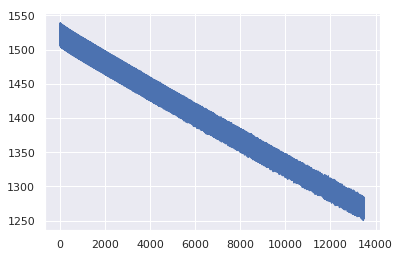

In [140]:
# ya mamma joke here
sns.lineplot(x=range(len(run_loss)), y=run_loss)

In [133]:
dim_reduced = {}
model.eval()

for k,v in tqdm(movies.items()):
    v = v.unsqueeze(0).to(cuda)
    dim_reduced[k] = model.encoder(v)

In [62]:
# For some reason it does not work smh
pickle.dump(dim_reduced,  open( "../data/infos_dim128.pytorch", "wb"))

## Principal component analysis

In [15]:
from sklearn.decomposition import PCA
import pickle
import torch
pca = PCA(128)

In [16]:
movies = pickle.load(open('../data/infos.pytorch', 'rb'))
data = torch.stack(list(movies.values()))
data[torch.isnan(data)] = 0

In [17]:
pca.fit(data.cpu().numpy())

PCA(copy=True, iterated_power='auto', n_components=128, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
dim_reduced = {}

for k,v in tqdm(movies.items()):
    v = v.numpy()
    v[np.isnan(v)] = 0
    dim_reduced[k] = torch.from_numpy(pca.transform(v.reshape(1, -1))).squeeze()

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(np.stack(list(dim_reduced.values())))

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [22]:
for k,v in tqdm(dim_reduced.items()):
    v = v.numpy()
    dim_reduced[k] = torch.from_numpy(scaler.transform(v.reshape(1, -1))).squeeze()

In [26]:
pickle.dump(dim_reduced,  open( "../data/infos_pca128.pytorch", "wb"))

tensor([-0.9792,  0.0043,  0.8163, -0.5884, -0.8780, -0.6665, -0.1932, -0.1978,
        -0.7542, -0.9578, -0.8184, -0.0325, -0.6117, -0.4928, -0.3506, -0.2742,
        -0.1464, -0.0573, -0.1902, -0.2422, -0.1715,  0.0085, -0.5535,  0.0557,
        -0.1806,  0.1446, -0.4688, -0.2541, -0.4518,  0.1903, -0.2160,  0.0037,
        -0.2260, -0.1706, -0.2285, -0.1242,  0.0975,  0.1135,  0.2490,  0.0379,
        -0.0513, -0.1658, -0.2578, -0.3545, -0.1038, -0.1746, -0.6506,  0.2479,
         0.0106,  0.0277, -0.4309, -0.2472, -0.0638,  0.0038, -0.1141,  0.1090,
        -0.1636,  0.1760, -0.2333,  0.0046, -0.1572, -0.0209, -0.0682, -0.1415,
        -0.2162,  0.1937,  0.1719, -0.0929,  0.0778,  0.0031,  0.0187,  0.0153,
         0.3572, -0.1546, -0.0959,  0.0734, -0.1497, -0.1169,  0.2613, -0.2581,
        -0.3272,  0.5021, -0.2477, -0.3021, -0.2637,  0.0461, -0.1885,  0.0593,
        -0.1661, -0.1981, -0.2349, -0.0871,  0.0390, -0.1982, -0.1311, -0.1953,
        -0.0153, -0.0904, -0.0487, -0.06